#2. 데이터 확인

In [1]:
import pandas as pd
import numpy as np
movies = [
  ['user1', '연평대전', 5],
  ['user1', '7번방의 선물', 4],
  ['user1', '국제시장', 4],
  ['user2', '연평대전', 5],
  ['user2', '7번방의 선물', 3],
  ['user2', '국제시장', 4],
  ['user2', '명랑', 5],
  ['user2', '국가대표', 3],
  # ['user3', '연평대전', 4],
  ['user3', '7번방의 선물', 3],
  # ['user3', '국제시장', 3],
  ['user3', '명랑', 3],
  ['user3', '국가대표', 5]
]

df_movies = pd.DataFrame(movies, columns=['userID', 'movieName', 'Rating'])
df_movies

,userID,movieName,Rating
0,user1,연평대전,5
1,user1,7번방의 선물,4
2,user1,국제시장,4
3,user2,연평대전,5
4,user2,7번방의 선물,3
5,user2,국제시장,4
6,user2,명랑,5
7,user2,국가대표,3
8,user3,7번방의 선물,3
9,user3,명랑,3


##3.1 데이터 가공

In [2]:
df_users = df_movies.pivot_table('Rating', index='userID', columns='movieName').fillna(0)
df_users

movieName,7번방의 선물,국가대표,국제시장,명랑,연평대전
userID,,,,,
user1,4.0,0.0,4.0,0.0,5.0
user2,3.0,3.0,4.0,5.0,5.0
user3,3.0,5.0,0.0,3.0,0.0


##3.2. 데이터 변환

#4. 영화간 유사도 산출

##4.1 사용자 기반 추천

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(df_users, df_users)
user_similarity

array([[1.        , 0.76594714, 0.24238715],
       [0.76594714, 1.        , 0.64891937],
       [0.24238715, 0.64891937, 1.        ]])

In [4]:
df_user_based = pd.DataFrame(data=user_similarity, index=df_users.index, columns=df_users.index)
df_user_based


userID,user1,user2,user3
userID,,,
user1,1.000000,0.765947,0.242387
user2,0.765947,1.000000,0.648919
user3,0.242387,0.648919,1.000000


> 사용자별 유사도를 확인하기 위해 간단하게 data frame으로 변환시켰다.

In [5]:
df_user_based['user1'].sort_values(ascending=False)

userID
user1    1.000000
user2    0.765947
user3    0.242387
Name: user1, dtype: float64

> user1과 유사도가 가장 높은 사용자는 user2임을 알 수 있다.

In [6]:
df_users.loc['user2'].sort_values(ascending=False)

movieName
연평대전       5.0
명랑         5.0
국제시장       4.0
국가대표       3.0
7번방의 선물    3.0
Name: user2, dtype: float64

> user1에서 추천하기 위해 user2이 본 영화를 내림차순으로 정렬하였다. 이 목록을 보고 user1에서 영화를 추천하면 된다. 

##4.2 Quiz
> user3에게 영화를 추천해 주세요

In [7]:
df_user_based['user3'].sort_values(ascending=False)

userID
user3    1.000000
user2    0.648919
user1    0.242387
Name: user3, dtype: float64

> user3과 가장 비슷한 영화 취향을 가진 유저는 user2이다. 

In [8]:
df_users.loc['user2':]

movieName,7번방의 선물,국가대표,국제시장,명랑,연평대전
userID,,,,,
user2,3.0,3.0,4.0,5.0,5.0
user3,3.0,5.0,0.0,3.0,0.0


> user2가 감상한 영화중 user3가 보지못한 영화를 추천해주면 될 것이다. (국제시장, 연평해전)

##강사님 코드

In [9]:
def UserBasedRecommand(data_frame, user_id):
  user_sim = cosine_similarity(data_frame, data_frame)
  df_user_based = pd.DataFrame(data=user_sim, index=data_frame.index, columns=data_frame.index)
  user_sorted = df_user_based[user_id].sort_values(ascending=False)
  #print(user_sorted.index[1])
  #print(user_sorted[1])
  return data_frame.loc[user_sorted.index[1]].sort_values(ascending=False)

Rec_movies_list = UserBasedRecommand(df_users, 'user3')
Rec_movies_list

movieName
연평대전       5.0
명랑         5.0
국제시장       4.0
국가대표       3.0
7번방의 선물    3.0
Name: user2, dtype: float64

##4.3 위 코드를 활용하여 user3가 안본 영화를 추천하시오

In [10]:
df_rating_movies_T = df_users.transpose()
df_rating_movies_T

df_nonmovies = df_rating_movies_T[df_rating_movies_T['user3']==0].iloc[0:, 1:]
df_nonmovies

df_nonmovies['user2'].sort_values(ascending=False)

movieName
연평대전    5.0
국제시장    4.0
Name: user2, dtype: float64

In [11]:
def UserBasedRecommand(data_frame, user_id):
  #유저들의 영화 평점을 보고 비슷한 정도를 나타냄
  user_sim = cosine_similarity(data_frame, data_frame)

  #비슷한 정도를 나타낸것을 DataFrame으로 만들어줌
  df_user_based = pd.DataFrame(data=user_sim, index=data_frame.index, columns=data_frame.index)

  # 이것을 검색하는 유저의 데이터를 기준으로 정렬
  user_sorted = df_user_based[user_id].sort_values(ascending=False)
  #print(user_sorted)

  #비슷한 정도는 자기스스로가 가장 높기때문에 그 다음을 뽑아 name을 보면 가장 비슷한 유저가 나옴
  sim_user_name = data_frame.loc[user_sorted.index[1]].sort_values(ascending=False).name

  #데이터 프레임을 뽑아 영화 이름을 인덱스로 만들어줌
  df_rating_movies_T = df_users.transpose()
  #이 데이터프레임에서 검색하는 유저가 안본영화(==0)인것을 뽑아줌
  df_nonmovies = df_rating_movies_T[df_rating_movies_T[user_id]==0].iloc[0:, 1:]

  #뽑은 영화를 비슷한 유저의 점수를 기반으로 정렬해서 리턴해줌
  return df_nonmovies[sim_user_name].sort_values(ascending=False)

Rec_movies_list = UserBasedRecommand(df_users, 'user3')
Rec_movies_list

movieName
연평대전    5.0
국제시장    4.0
Name: user2, dtype: float64

##4.4 영화 기반 추천


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

movies_sim = cosine_similarity(df_rating_movies_T, df_rating_movies_T)
movies_sim

array([[1.        , 0.70588235, 0.84887469, 0.70588235, 0.84887469],
       [0.70588235, 1.        , 0.36380344, 0.88235294, 0.36380344],
       [0.84887469, 0.36380344, 1.        , 0.60633906, 1.        ],
       [0.70588235, 0.88235294, 0.60633906, 1.        , 0.60633906],
       [0.84887469, 0.36380344, 1.        , 0.60633906, 1.        ]])

In [13]:
item_based = pd.DataFrame(data=movies_sim, index=df_rating_movies_T.index, columns=df_rating_movies_T.index)
item_based

movieName,7번방의 선물,국가대표,국제시장,명랑,연평대전
movieName,,,,,
7번방의 선물,1.000000,0.705882,0.848875,0.705882,0.848875
국가대표,0.705882,1.000000,0.363803,0.882353,0.363803
국제시장,0.848875,0.363803,1.000000,0.606339,1.000000
명랑,0.705882,0.882353,0.606339,1.000000,0.606339
연평대전,0.848875,0.363803,1.000000,0.606339,1.000000


In [14]:
item_based['7번방의 선물'].sort_values(ascending=False)[1:]

movieName
연평대전    0.848875
국제시장    0.848875
명랑      0.705882
국가대표    0.705882
Name: 7번방의 선물, dtype: float64

> 7번방의 선물과 유사도가 높은 영화들을 추출하였다. [1:]을 통해 자기 자신은 제외 시켰다.

#5. 예측 평점

In [15]:
print('사용자 평점\n', df_users.values)

사용자 평점
 [[4. 0. 4. 0. 5.]
 [3. 3. 4. 5. 5.]
 [3. 5. 0. 3. 0.]]


In [16]:
print('영화별 유사도\n', movies_sim)

영화별 유사도
 [[1.         0.70588235 0.84887469 0.70588235 0.84887469]
 [0.70588235 1.         0.36380344 0.88235294 0.36380344]
 [0.84887469 0.36380344 1.         0.60633906 1.        ]
 [0.70588235 0.88235294 0.60633906 1.         0.60633906]
 [0.84887469 0.36380344 1.         0.60633906 1.        ]]


In [17]:
print('영화별 유사도\n', item_based.values)

영화별 유사도
 [[1.         0.70588235 0.84887469 0.70588235 0.84887469]
 [0.70588235 1.         0.36380344 0.88235294 0.36380344]
 [0.84887469 0.36380344 1.         0.60633906 1.        ]
 [0.70588235 0.88235294 0.60633906 1.         0.60633906]
 [0.84887469 0.36380344 1.         0.60633906 1.        ]]


In [18]:
print('내적\n', df_users.values.dot(movies_sim))
print('내적\n', df_users.values.dot(item_based.values))

내적
 [[11.63987219  6.09776035 12.39549875  8.28058098 12.39549875]
 [16.28693101 12.8036427  15.66972969 15.22175745 15.66972969]
 [ 8.64705882  9.76470588  6.18465844  9.52941176  6.18465844]]
내적
 [[11.63987219  6.09776035 12.39549875  8.28058098 12.39549875]
 [16.28693101 12.8036427  15.66972969 15.22175745 15.66972969]
 [ 8.64705882  9.76470588  6.18465844  9.52941176  6.18465844]]


> 예측 평점을 구할 경우 분자는 '사용자평점'과 '영화별 유사도'의 내적으로 구하게 된다.

> 사용자 평점은 df_users.values로 구할 수 있다.

> 영화별 유사도는 movies_sim 또는 item_based.values로 구할 수 있다.

> 내적은 dot함수를 이용하여 구할 수 잇다.

In [19]:
import numpy as np

print(np.abs(movies_sim))
print(np.abs(movies_sim).sum(axis=1))
print(np.array([np.abs(movies_sim).sum(axis=1)]))

[[1.         0.70588235 0.84887469 0.70588235 0.84887469]
 [0.70588235 1.         0.36380344 0.88235294 0.36380344]
 [0.84887469 0.36380344 1.         0.60633906 1.        ]
 [0.70588235 0.88235294 0.60633906 1.         0.60633906]
 [0.84887469 0.36380344 1.         0.60633906 1.        ]]
[4.10951408 3.31584217 3.81901719 3.80091342 3.81901719]
[[4.10951408 3.31584217 3.81901719 3.80091342 3.81901719]]


> 예측평점에서 분모가 되는 부분으로, 유사도에 대한 절대값의 합을 구하는 코드이다.

In [20]:
def predict_rating(rating, item_sim):
  return rating.dot(item_sim)/np.array([np.abs(item_sim).sum(axis=1)])

rating_pred = predict_rating(df_users.values, movies_sim)
rating_pred

array([[2.83242056, 1.83897786, 3.24573002, 2.17857658, 3.24573002],
       [3.9632255 , 3.86135469, 4.10307912, 4.004763  , 4.10307912],
       [2.10415603, 2.9448645 , 1.61943718, 2.50713729, 1.61943718]])

In [21]:
df_users.values

array([[4., 0., 4., 0., 5.],
       [3., 3., 4., 5., 5.],
       [3., 5., 0., 3., 0.]])

#6. 평균 제곱 오차
> 추측값에 대한 정확도를 측정하기 위해 평균 제곱 오차를 사용한다. 값이 클수록 오차가 크다고 판단할 수 있다.

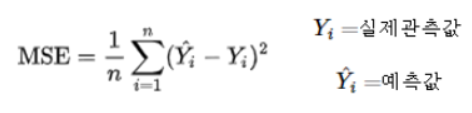

> 예측값에서 실제 값을 뺀 값의 제곱에 대한 평균으로 두 값에 대한 편차이므로 값이 크게 되면 예측값이 잘못되었다는 것을 알 수 있다.

In [22]:
print('편차 : \n', rating_pred - df_users.values)
print('편차 제곱: \n', np.square(rating_pred - df_users.values))

편차 : 
 [[-1.16757944  1.83897786 -0.75426998  2.17857658 -1.75426998]
 [ 0.9632255   0.86135469  0.10307912 -0.995237   -0.89692088]
 [-0.89584397 -2.0551355   1.61943718 -0.49286271  1.61943718]]
편차 제곱: 
 [[1.36324174 3.38183958 0.5689232  4.74619593 3.07746315]
 [0.92780337 0.7419319  0.01062531 0.99049668 0.80446706]
 [0.80253642 4.22358194 2.62257679 0.24291365 2.62257679]]


In [23]:
rating_square = np.square(rating_pred - df_users.values)
print(rating_square.reshape(-1).mean())
print(rating_square.flatten().mean())
print(rating_square.ravel().mean())

1.8084782338349181
1.8084782338349181
1.8084782338349181


> 위의 reshape, flatten, ravel 모두 1차원으로 변환시켜 주는 함수이다.

In [24]:
# %timeit  시간을 채크해주는 함수, flatten이 제일 오래걸리는데 복사해서 사용하기 때문이다.
%timeit rating_square.reshape(-1).mean()
%timeit rating_square.flatten().mean()
%timeit rating_square.ravel().mean()

The slowest run took 22.65 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 6.77 µs per loop
The slowest run took 8.89 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 7.09 µs per loop
The slowest run took 7.22 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 5.97 µs per loop


> 각 동작 시간을 비교해 보면 ravel -> reshape -> flatten 순으로 처리되는 것을 볼 수 있다. flatten은 다른 함수와 다르게 원본을 복사하여 사용하기 때문에 약간의 지연시간이 발생하여 느리게 나타난다.

#7. 비평가 영화 제거

In [25]:
print('원본 \n', df_users.values)
print('비평가 영화 제거 \n', df_users.values.nonzero())

원본 
 [[4. 0. 4. 0. 5.]
 [3. 3. 4. 5. 5.]
 [3. 5. 0. 3. 0.]]
비평가 영화 제거 
 (array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]), array([0, 2, 4, 0, 1, 2, 3, 4, 0, 1, 3]))


> nonzero는 0이 아닌값을 찾아주는 함수로 첫번째 결과는 0이아닌 데이터의 갯수를, 두번째 결과는 index정보를 갖게 된다.

In [26]:
rating_pred[df_users.values.nonzero()]

array([2.83242056, 3.24573002, 3.24573002, 3.9632255 , 3.86135469,
       4.10307912, 4.004763  , 4.10307912, 2.10415603, 2.9448645 ,
       2.50713729])

In [27]:
def get_mes1(pred, data_frame):
  rating_pred_nonzero = pred[data_frame.nonzero()]
  df_rating_nonzero = data_frame[data_frame.nonzero()]

  square = np.square(rating_pred_nonzero - df_rating_nonzero)
  return square.mean()

get_mes1(rating_pred, df_users.values)

1.250362218706176

In [28]:
from sklearn.metrics import mean_squared_error
def get_mes1(pred, data_frame):
  rating_pred_nonzero = pred[data_frame.nonzero()]
  df_rating_nonzero = data_frame[data_frame.nonzero()]

  #square = np.square(rating_pred_nonzero - df_rating_nonzero)
  #return square.mean()
  return mean_squared_error(rating_pred_nonzero, df_rating_nonzero)

get_mes1(rating_pred, df_users.values)

1.250362218706176

#8. 상위 데이터 추천

In [29]:
ratings_arr = df_users.values
ratings_arr

array([[4., 0., 4., 0., 5.],
       [3., 3., 4., 5., 5.],
       [3., 5., 0., 3., 0.]])

In [30]:
#0번째 행의 모든 값 출력
print(np.argsort(ratings_arr[0, :]))
print(np.argsort(ratings_arr[0, :])[:])

#0번째행의 4번째 값까지 출력
print(np.argsort(ratings_arr[0, :])[:4])
#0번째 행의 뒤에서 1번째까지 출력
print(np.argsort(ratings_arr[0, :])[:-1])

#0번째 행의 뒤에서 4번째까지 출력
print(np.argsort(ratings_arr[0, :])[:-4])
#0번째 행의 1번째 값까지 출력
print(np.argsort(ratings_arr[0, :])[:1])

#0번째 행의 뒤에서 4번째 값을 역순으로 출력하게 되어 뒤의 3개의 값이 나옴
#아래의 코드는 상위3개의 데이터만 추출하는 코드로 가장 아래 코드를 사용하면됨.
print(np.argsort(ratings_arr[0, :])[:-4:-1])
print(np.argsort(ratings_arr[0, :])[:1:-1])

print(np.argsort(ratings_arr[0, :])[::-1])
print(np.argsort(ratings_arr[0, :])[::-1][:3])

[1 3 0 2 4]
[1 3 0 2 4]
[1 3 0 2]
[1 3 0 2]
[1]
[1]
[4 2 0]
[4 2 0]
[4 2 0 3 1]
[4 2 0]


In [31]:
n = 3
top_n_item = np.argsort(ratings_arr[0, :])[::-1][:n]
print(top_n_item)
print(ratings_arr[0, :][top_n_item])

[4 2 0]
[5. 4. 4.]


> argsort는 정렬한 결과를 index정보로 반환하는 것으로 위의 코드에서는 내림차순으로 정렬한 후 n개의 값, 즉 3개의 값을 추출하게 된다.

> 이 index정보를 이용하여 ratings_arr에 있는 top3 데이터들을 얻을 수 잇다.

In [32]:
print(ratings_arr.shape)

pred = np.zeros(ratings_arr.shape)
print(pred)

(3, 5)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [33]:
item_sim = item_based.values
item_sim

array([[1.        , 0.70588235, 0.84887469, 0.70588235, 0.84887469],
       [0.70588235, 1.        , 0.36380344, 0.88235294, 0.36380344],
       [0.84887469, 0.36380344, 1.        , 0.60633906, 1.        ],
       [0.70588235, 0.88235294, 0.60633906, 1.        , 0.60633906],
       [0.84887469, 0.36380344, 1.        , 0.60633906, 1.        ]])

In [34]:
print(item_sim[:, 1])
print(item_sim[:, 1][top_n_item])

[0.70588235 1.         0.36380344 0.88235294 0.36380344]
[0.36380344 0.36380344 0.70588235]


In [35]:
for i in range(n):
  pred[i,1] = item_sim[:, 1][top_n_item].dot(ratings_arr[i, :][top_n_item])
  pred[i,4] = item_sim[:, 4][top_n_item].dot(ratings_arr[i, :][top_n_item])


pred

array([[ 0.        ,  6.09776035,  0.        ,  0.        , 12.39549875],
       [ 0.        ,  5.391878  ,  0.        ,  0.        , 11.54662406],
       [ 0.        ,  2.11764706,  0.        ,  0.        ,  2.54662406]])

In [36]:
print(item_sim)
print(item_sim[1, :])
print(item_sim[1, :][top_n_item])
print(np.abs(item_sim[1, :][top_n_item]))
print(np.sum(np.abs(item_sim[1, :][top_n_item])))

[[1.         0.70588235 0.84887469 0.70588235 0.84887469]
 [0.70588235 1.         0.36380344 0.88235294 0.36380344]
 [0.84887469 0.36380344 1.         0.60633906 1.        ]
 [0.70588235 0.88235294 0.60633906 1.         0.60633906]
 [0.84887469 0.36380344 1.         0.60633906 1.        ]]
[0.70588235 1.         0.36380344 0.88235294 0.36380344]
[0.36380344 0.36380344 0.70588235]
[0.36380344 0.36380344 0.70588235]
1.433489228050175


In [37]:
def predict_rating_top(ratings_arr, item_sim, top=10):
  #예상 점수를 저장할 공간 확보
  pred = np.zeros(ratings_arr.shape)

  #상위 데이터 추출, 각 user별 상위 3개의 평점 추출
  for row in range(ratings_arr.shape[0]):
    top_n_item = np.argsort(ratings_arr[row, :][::-1][:top])
    #상위 데이터 추출
    for col in range(ratings_arr.shape[1]):
      pred[row, col] = item_sim[:, col][top_n_item].dot(ratings_arr[row, :][top_n_item])
      pred[row, col] /= np.sum(np.abs(item_sim[col, :][top_n_item]))
      

  return pred
  
  #예상 평점 구하기


predict_rating_top(df_users.values, item_sim, 3)
print(rating_pred)
print(get_mes1(rating_pred, df_users.values))

[[2.83242056 1.83897786 3.24573002 2.17857658 3.24573002]
 [3.9632255  3.86135469 4.10307912 4.004763   4.10307912]
 [2.10415603 2.9448645  1.61943718 2.50713729 1.61943718]]
1.250362218706176


> 결론적으로 상위3개의 점수만으로 예측점수를 구하여 0점이 제외되었고 이로인해 MSE 점수도 낮게 나온 것을 확인했다. 실 점수화의 차이가 많이 줄어 든 것을 알 수있다.

# 9. 개인추천

In [39]:
user1_movies = df_users.loc['user1']
user1_movies

movieName
7번방의 선물    4.0
국가대표       0.0
국제시장       4.0
명랑         0.0
연평대전       5.0
Name: user1, dtype: float64

> user1이 가지고 있는 모든 영화 정보이다.

In [40]:
user1_movies[user1_movies>0].sort_values(ascending=False)

movieName
연평대전       5.0
국제시장       4.0
7번방의 선물    4.0
Name: user1, dtype: float64

> user1이 평가한 정렬된 영화 정보이다.

> 사용자가 안본 영화 추출

In [57]:
def nonPlayedMovie(data_frame, user_name):
  #사용자의 영화정보 추출
  user_movies = data_frame.loc[user_name]
  #사용자가 본 영화 추출
  already_seen = user_movies[user_movies>0]
  #전체 영화 목록 추출
  movie_list = data_frame.columns

  #전체 영화중 사용자가 본 영화를 빼고 나머지 리턴
  return movie_list[~movie_list.isin(already_seen.index)]

  #사실 아래처럼 작성하면 빠르고 간단하다.
  #unseen_list = user_movies[user_movies==0]
  #return unseen_list.index.to_list()

unseen_list = nonPlayedMovie(df_users, 'user1')

> 위 코드처럼 설계를 어떻게 하느냐에 따라 코드의 양이 달라진다.

In [58]:
#사용자별 영화 목록을 추출하기 위해  dataframe 생성
df_ratings_pred = pd.DataFrame(data=rating_pred, index=df_users.index, columns=df_users.columns)

#user1의 모든 영화 목록 얻기
user1_movies = df_ratings_pred.loc['user1']

# user1이 안본 영화를 예상 평점 순으로 정렬
user1_movies[unseen_list.tolist()].sort_values(ascending=False)

movieName
명랑      2.178577
국가대표    1.838978
Name: user1, dtype: float64